# Sktime workshop: Pycon Colombia 2025 (Part 2)

![](imgs/sktime-logo.png)


2. **Forecasting panel data with sktime** (30 min)
   1. Data representation for panel data
   2. Upcasting feature in sktime
   3. Panel forecasting with Machine Learning models

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
from pycon_workshop.dataset import PyConWorkshopDataset

dataset = PyConWorkshopDataset("panel")

y_train, y_test, X_train, X_test = dataset.load("y_train", "y_test", "X_train", "X_test")

display(y_train)

sales
sku_id date             
0      2020-01-01      0
       2020-01-02      1
       2020-01-03      1
       2020-01-04      1
       2020-01-05      0
...                  ...
49     2024-07-01     71
       2024-07-02     45
       2024-07-03     40
       2024-07-04     18
       2024-07-05     18

[82400 rows x 1 columns]

In [3]:
y_train.index.get_level_values(-1)


PeriodIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
             '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
             '2020-01-09', '2020-01-10',
             ...
             '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29',
             '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03',
             '2024-07-04', '2024-07-05'],
            dtype='period[D]', name='date', length=82400)

In pandas, the following operations are useful:

In [4]:
y_train.index

MultiIndex([( 0, '2020-01-01'),
            ( 0, '2020-01-02'),
            ( 0, '2020-01-03'),
            ( 0, '2020-01-04'),
            ( 0, '2020-01-05'),
            ( 0, '2020-01-06'),
            ( 0, '2020-01-07'),
            ( 0, '2020-01-08'),
            ( 0, '2020-01-09'),
            ( 0, '2020-01-10'),
            ...
            (49, '2024-06-26'),
            (49, '2024-06-27'),
            (49, '2024-06-28'),
            (49, '2024-06-29'),
            (49, '2024-06-30'),
            (49, '2024-07-01'),
            (49, '2024-07-02'),
            (49, '2024-07-03'),
            (49, '2024-07-04'),
            (49, '2024-07-05')],
           names=['sku_id', 'date'], length=82400)

In [5]:
y_train.index.get_level_values(0).unique()

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype='int64', name='sku_id')

In [6]:
y_train.loc[0]

,sales
date,
2020-01-01,0
2020-01-02,1
2020-01-03,1
2020-01-04,1
2020-01-05,0
...,...
2024-07-01,31
2024-07-02,50
2024-07-03,73


In [7]:
y_train.loc[pd.IndexSlice[[0,2], :]]

sales
sku_id date             
0      2020-01-01      0
       2020-01-02      1
       2020-01-03      1
       2020-01-04      1
       2020-01-05      0
...                  ...
2      2024-07-01     72
       2024-07-02     67
       2024-07-03     76
       2024-07-04     73
       2024-07-05     78

[3296 rows x 1 columns]

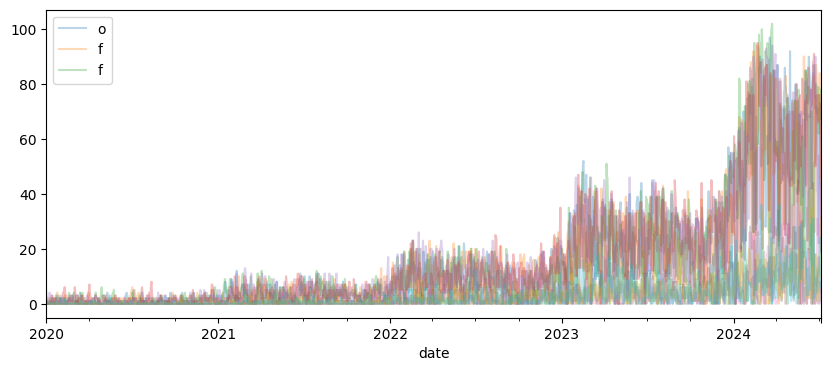

In [8]:
from sktime.utils.plotting import plot_series

fig, ax = plt.subplots(figsize=(10, 4))
y_train.unstack(level=0).droplevel(0, axis=1).iloc[:, :10].plot(ax=ax, alpha=0.3)
ax.legend("off")

In [9]:
X_train

promo  macro_index
sku_id date                          
0      2020-01-01    0.0    98.196255
       2020-01-02    1.0    99.613209
       2020-01-03    0.0   103.098493
       2020-01-04    0.0   101.083814
       2020-01-05    0.0   102.708703
...                  ...          ...
49     2024-07-01    0.0    98.750890
       2024-07-02    0.0   103.205447
       2024-07-03    0.0   100.525961
       2024-07-04    0.0    98.038401
       2024-07-05    0.0   101.780786

[82400 rows x 2 columns]

In [10]:
y_train

sales
sku_id date             
0      2020-01-01      0
       2020-01-02      1
       2020-01-03      1
       2020-01-04      1
       2020-01-05      0
...                  ...
49     2024-07-01     71
       2024-07-02     45
       2024-07-03     40
       2024-07-04     18
       2024-07-05     18

[82400 rows x 1 columns]

In [11]:
fh = y_test.index.get_level_values(1).unique()

In [12]:
fh

PeriodIndex(['2024-07-06', '2024-07-07', '2024-07-08', '2024-07-09',
             '2024-07-10', '2024-07-11', '2024-07-12', '2024-07-13',
             '2024-07-14', '2024-07-15',
             ...
             '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26',
             '2024-12-27', '2024-12-28', '2024-12-29', '2024-12-30',
             '2024-12-31', '2025-01-01'],
            dtype='period[D]', name='date', length=180)

## Automatic upcasting

No extra lines needed! Automatically upcast to panel data when using `sktime` estimators.

In [13]:
from sktime.forecasting.naive import NaiveForecaster


naive_forecaster = NaiveForecaster(strategy="last", window_length=1)
naive_forecaster.fit(y_train)
y_pred_naive = naive_forecaster.predict(fh=fh)

y_pred_naive

sales
sku_id date             
0      2024-07-06   71.0
       2024-07-07   71.0
       2024-07-08   71.0
       2024-07-09   71.0
       2024-07-10   71.0
...                  ...
49     2024-12-28   18.0
       2024-12-29   18.0
       2024-12-30   18.0
       2024-12-31   18.0
       2025-01-01   18.0

[9000 rows x 1 columns]

Now that we have multiple series, we need to explain to the metric how to handle this!

* Use `multilevel="uniform_average_time"` to average the time series across the panel.
* Use `multilevel="raw_values"` to obtain the error per series.

In [14]:
from sktime.performance_metrics.forecasting import MeanSquaredScaledError

metric = MeanSquaredScaledError(multilevel="uniform_average_time")

In [15]:
metric(y_true=y_test, y_pred=y_pred_naive, y_train=y_train)

18.492784760639832

## Machine learning models for timeseries forecasting

![](imgs/global_reduction.png)

<Axes: xlabel='date'>

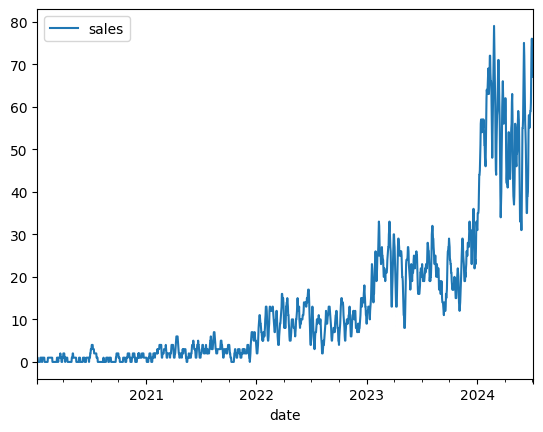

In [16]:
y_train.groupby(level=0).rolling(7).mean().dropna().astype(int).loc[(1, 1)].plot.line()

In [17]:
from sktime.transformations.series.summarize import WindowSummarizer

summarizer = WindowSummarizer(
    lag_feature={
        "lag" : list(range(1,20)),
        "std" : [list(range(1,20))],
    },
)

summarizer.fit_transform(y_train, X_train)


sales_lag_1  sales_lag_18  sales_lag_17  sales_lag_16  \
sku_id date                                                                
0      2020-01-01          NaN           NaN           NaN           NaN   
       2020-01-02          0.0           NaN           NaN           NaN   
       2020-01-03          1.0           NaN           NaN           NaN   
       2020-01-04          1.0           NaN           NaN           NaN   
       2020-01-05          1.0           NaN           NaN           NaN   
...                        ...           ...           ...           ...   
49     2024-07-01         73.0          51.0          56.0          56.0   
       2024-07-02         71.0          56.0          56.0          57.0   
       2024-07-03         45.0          56.0          57.0          56.0   
       2024-07-04         40.0          57.0          56.0          78.0   
       2024-07-05         18.0          56.0          78.0          77.0   

                   sales_lag_15  sales_lag_14  sales_lag_13  sales_lag_12  \
sku_id date                                                                 
0      2020-01-01           NaN           NaN           NaN           NaN   
       2020-01-02           NaN           NaN           NaN           NaN   
       2020-01-03           NaN           NaN           NaN           NaN   
       2020-01-04           NaN           NaN           NaN           NaN   
       2020-01-05           NaN           NaN           NaN           NaN   
...                         ...           ...           ...           ...   
49     2024-07-01          57.0          56.0          78.0          77.0   
       2024-07-02          56.0          78.0          77.0          78.0   
       2024-07-03          78.0          77.0          78.0          55.0   
       2024-07-04          77.0          78.0          55.0          55.0   
       2024-07-05          78.0          55.0          55.0          51.0   

                   sales_lag_11  sales_lag_19  sales_lag_9  sales_lag_8  \
sku_id date                                                               
0      2020-01-01           NaN           NaN          NaN          NaN   
       2020-01-02           NaN           NaN          NaN          NaN   
       2020-01-03           NaN           NaN          NaN          NaN   
       2020-01-04           NaN           NaN          NaN          NaN   
       2020-01-05           NaN           NaN          NaN          NaN   
...                         ...           ...          ...          ...   
49     2024-07-01          78.0          23.0         55.0         51.0   
       2024-07-02          55.0          51.0         51.0         82.0   
       2024-07-03          55.0          56.0         82.0         78.0   
       2024-07-04          51.0          56.0         78.0         78.0   
       2024-07-05          82.0          57.0         78.0         69.0   

                   sales_lag_10  sales_lag_6  sales_lag_2  sales_lag_5  \
sku_id date                                                              
0      2020-01-01           NaN          NaN          NaN          NaN   
       2020-01-02           NaN          NaN          NaN          NaN   
       2020-01-03           NaN          NaN          0.0          NaN   
       2020-01-04           NaN          NaN          1.0          NaN   
       2020-01-05           NaN          NaN          1.0          NaN   
...                         ...          ...          ...          ...   
49     2024-07-01          55.0         78.0         72.0         78.0   
       2024-07-02          55.0         78.0         73.0         69.0   
       2024-07-03          51.0         69.0         71.0         70.0   
       2024-07-04          82.0         70.0         45.0         72.0   
       2024-07-05          78.0         72.0         40.0         73.0   

                   sales_lag_3  sales_lag_4  sales_lag_7  \
sku_id date                  

In [18]:
y_test

sales
sku_id date             
0      2024-07-06     69
       2024-07-07     69
       2024-07-08     77
       2024-07-09     76
       2024-07-10     77
...                  ...
49     2024-12-28     90
       2024-12-29     98
       2024-12-30    101
       2024-12-31    107
       2025-01-01    100

[9000 rows x 1 columns]

In [19]:
from sktime.forecasting.compose import RecursiveReductionForecaster, make_reduction
from sklearn.ensemble import RandomForestRegressor

forecaster = make_reduction(
    RandomForestRegressor(n_estimators=20, random_state=42),
    strategy="recursive",
    pooling="global",
    window_length=None,
    transformers=[summarizer]
)

forecaster.fit(y_train, X_train)

RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=20, random_state=42),
                                     pooling='global',
                                     transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                         2,
                                                                                         3,
                                                                                         4,
                                                                                         5,
                                                                                         6,
                                                                                         7,
                                                                                         8,
                                                                                         9,
                                                                                         10,
                                                                                         11,
                                                                                         12,
                                                                                         13,
                                                                                         14,
                                                                                         15,
                                                                                         16,
                                                                                         17,
                                                                                         18,
                                                                                         19],
                                                                                 'std': [[1,
                                                                                          2,
                                                                                          3,
                                                                                          4,
                                                                                          5,
                                                                                          6,
                                                                                          7,
                                                                                          8,
                                                                                          9,
                                                                                          10,
                                                                                          11,
                                                                                          12,
                                                                                          13,
                                                                                          14,
                                                                                          15,
                                                                                          16,
                                                                                          17,
                                                                                          18,
                                                                                          19]]})],
                                     window_length=None)

In [20]:
y_pred_global1 = forecaster.predict(fh=fh, X=X_test)

<Axes: xlabel='date'>

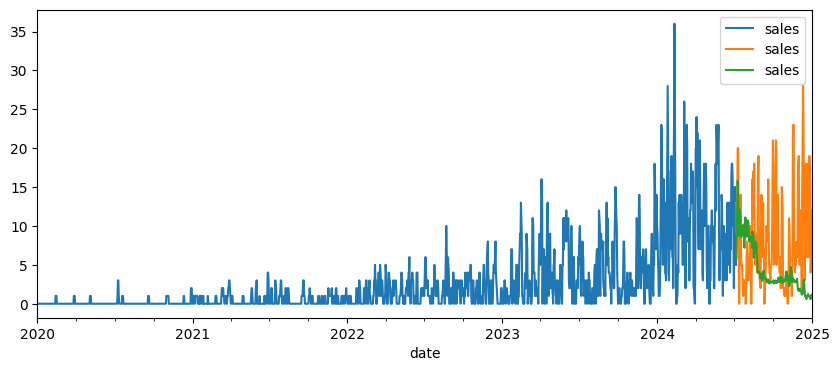

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))
y_train.loc[10].plot(ax=ax, label="Train")
y_test.loc[10].plot(ax=ax, label="Test")
y_pred_global1.loc[10].plot(ax=ax, label="Global 1")

In [22]:
metric(y_true=y_test, y_pred=y_pred_global1, y_train=y_train)

17.548387885469992

In [23]:
from sklearn.preprocessing import StandardScaler


forecaster_scaled = StandardScaler() * forecaster

forecaster_scaled.fit(y_train, X_train)

TransformedTargetForecaster(steps=[TabularToSeriesAdaptor(transformer=StandardScaler()),
                                   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=20, random_state=42),
                                                                        pooling='global',
                                                                        transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                            2,
                                                                                                                            3,
                                                                                                                            4,
                                                                                                                            5,
                                                                                                                            6,
                                                                                                                            7,
                                                                                                                            8,
                                                                                                                            9,
                                                                                                                            10,
                                                                                                                            11,
                                                                                                                            12,
                                                                                                                            13,
                                                                                                                            14,
                                                                                                                            15,
                                                                                                                            16,
                                                                                                                            17,
                                                                                                                            18,
                                                                                                                            19],
                                                                                                                    'std': [[1,
                                                                                                                             2,
                                                                                                                             3,
                                                                                                                             4,
                                                                                                                             5,
                                                                                                                             6,
                                                                                                                             7,
                                                                                                                             8,
                                                                                                                             9,
                                                                                                          

In [24]:
y_pred_global2 = forecaster_scaled.predict(fh=fh, X=X_test)

In [25]:
metric(y_true=y_test, y_pred=y_pred_global2, y_train=y_train)

23.13191799902905

<Axes: xlabel='date'>

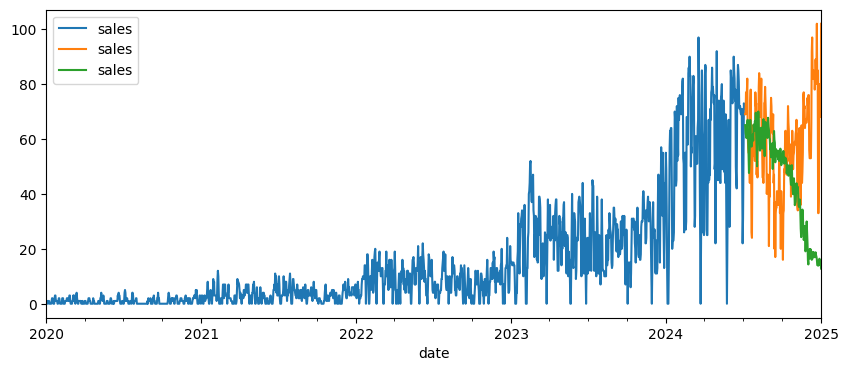

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))
y_train.loc[0].plot(ax=ax, label="Train")
y_test.loc[0].plot(ax=ax, label="Test")
y_pred_global2.loc[0].plot(ax=ax, label="Global 1")

In [27]:
from sktime.transformations.series.difference import Differencer

forecaster_diff = Differencer() * forecaster_scaled
forecaster_diff.fit(y_train, X_train)

TransformedTargetForecaster(steps=[Differencer(),
                                   TabularToSeriesAdaptor(transformer=StandardScaler()),
                                   RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=20, random_state=42),
                                                                        pooling='global',
                                                                        transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                            2,
                                                                                                                            3,
                                                                                                                            4,
                                                                                                                            5,
                                                                                                                            6,
                                                                                                                            7,
                                                                                                                            8,
                                                                                                                            9,
                                                                                                                            10,
                                                                                                                            11,
                                                                                                                            12,
                                                                                                                            13,
                                                                                                                            14,
                                                                                                                            15,
                                                                                                                            16,
                                                                                                                            17,
                                                                                                                            18,
                                                                                                                            19],
                                                                                                                    'std': [[1,
                                                                                                                             2,
                                                                                                                             3,
                                                                                                                             4,
                                                                                                                             5,
                                                                                                                             6,
                                                                                                                             7,
                                                                                                                             8,
                                                                                                                             9,
                                                        

In [28]:
y_pred_global3= forecaster_diff.predict(fh=fh, X=X_test)
metric(y_true=y_test, y_pred=y_pred_global3, y_train=y_train)

11.250149151256423

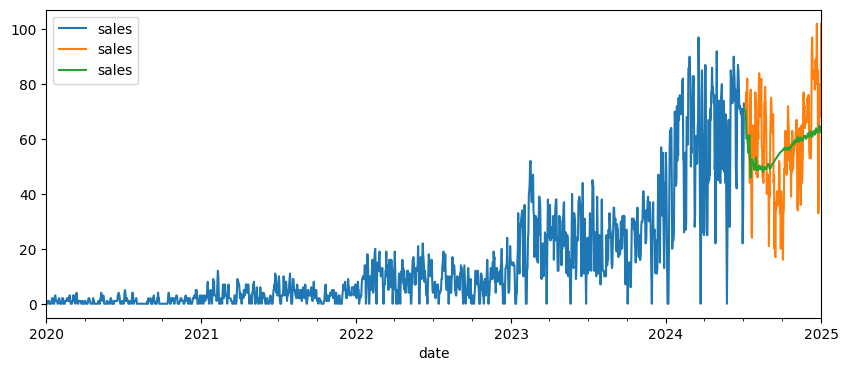

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))
y_train.loc[0].plot(ax=ax, label="Train")
y_test.loc[0].plot(ax=ax, label="Test")
y_pred_global3.loc[0].plot(ax=ax, label="Global 1")
fig.show()

In [30]:
from sktime.transformations.series.fourier import FourierFeatures
from sktime.transformations.series.boxcox import LogTransformer

fourier_features = FourierFeatures(sp_list=[365.25], fourier_terms_list=[2], freq="D", keep_original_columns=True)

forecaster_diff2 = fourier_features ** ( forecaster_diff)

forecaster_diff2.fit(y_train, X_train)

ForecastingPipeline(steps=[FourierFeatures(fourier_terms_list=[2], freq='D',
                                           keep_original_columns=True,
                                           sp_list=[365.25]),
                           TransformedTargetForecaster(steps=[Differencer(),
                                                              TabularToSeriesAdaptor(transformer=StandardScaler()),
                                                              RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=20, random_state=42),
                                                                                                   pooling='global',
                                                                                                   transformers=[WindowSummarizer(lag_feature={'lag': [1,
                                                                                                                                                       2,
                                                                                                                                                       3,
                                                                                                                                                       4,
                                                                                                                                                       5,
                                                                                                                                                       6,
                                                                                                                                                       7,
                                                                                                                                                       8,
                                                                                                                                                       9,
                                                                                                                                                       10,
                                                                                                                                                       11,
                                                                                                                                                       12,
                                                                                                                                                       13,
                                                                                                                                                       14,
                                                                                                                                                       15,
                                                                                                                                                       16,
                                                                                                                                                       17,
                                                                                                                                                       18,
                                                                                                                                                       19],
                                                                                                                                               'std': [[1,
                                                                                                                                                        2,
                                                                   

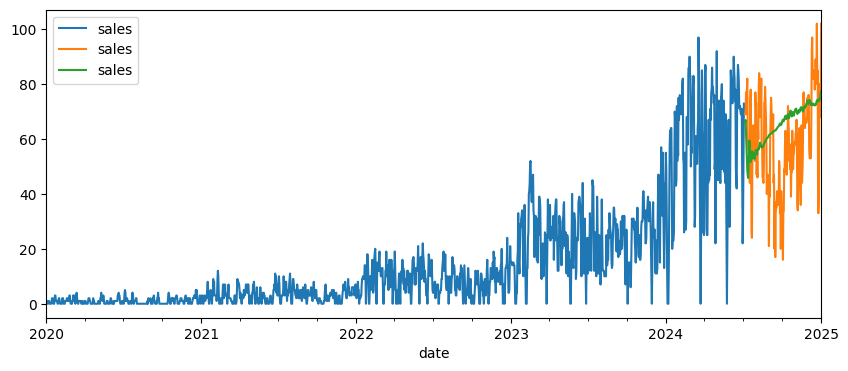

In [31]:
y_pred_global4 = forecaster_diff2.predict(fh=fh, X=X_test)
fig, ax = plt.subplots(figsize=(10, 4))
y_train.loc[0].plot(ax=ax, label="Train")
y_test.loc[0].plot(ax=ax, label="Test")
y_pred_global4.loc[0].plot(ax=ax, label="Global 2")
fig.show()

In [32]:
metric(y_true=y_test, y_pred=y_pred_global4, y_train=y_train)

12.152766814927194

## Deep learning models

In [ ]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats
from pytorch_forecasting.data.encoders import EncoderNormalizer

CONTEXT_LENGTH = 30
nbeats = PytorchForecastingNBeats(
    train_to_dataloader_params={"batch_size": 256},
    trainer_params={"max_epochs": 1},
    model_params={
        "stack_types": ["trend", "seasonality"], # One of the following values: “generic”, “seasonality” or “trend”.
        "num_blocks" : [2,2], # The number of blocks per stack. 
        "context_length": CONTEXT_LENGTH, # lookback period
        "expansion_coefficient_lengths" : [3, 4],
        "learning_rate": 1e-3,
    },
    dataset_params={

        "max_encoder_length": CONTEXT_LENGTH,
        "target_normalizer": EncoderNormalizer()
    },
)

nbeats.fit(y_train.astype(float), fh=fh)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 1.3 M  | train
-------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.092     Total estimated model params size (MB)
60        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 245/245 [00:26<00:00,  9.36it/s, v_num=15, train_loss_step=1.700, val_loss=2.210, train_loss_epoch=1.720]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 245/245 [00:26<00:00,  9.34it/s, v_num=15, train_loss_step=1.700, val_loss=2.210, train_loss_epoch=1.720]


PytorchForecastingNBeats(dataset_params={'max_encoder_length': 30,
                                         'target_normalizer': EncoderNormalizer(
	method='standard',
	center=True,
	max_length=None,
	transformation=None,
	method_kwargs={}
)},
                         model_params={'context_length': 30,
                                       'expansion_coefficient_lengths': [3, 4],
                                       'learning_rate': 0.001,
                                       'num_blocks': [2, 2],
                                       'stack_types': ['trend', 'seasonality']},
                         train_to_dataloader_params={'batch_size': 256},
                         trainer_params={'max_epochs': 1})

In [42]:
y_pred_nbeats = nbeats.predict(fh=fh, X=X_test)

/Users/felipeangelim/Workspace/sktime-workshop-pycon-colombia-2025/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:656: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [43]:
metric(y_true=y_test, y_pred=y_pred_nbeats, y_train=y_train)

9.006004600188755

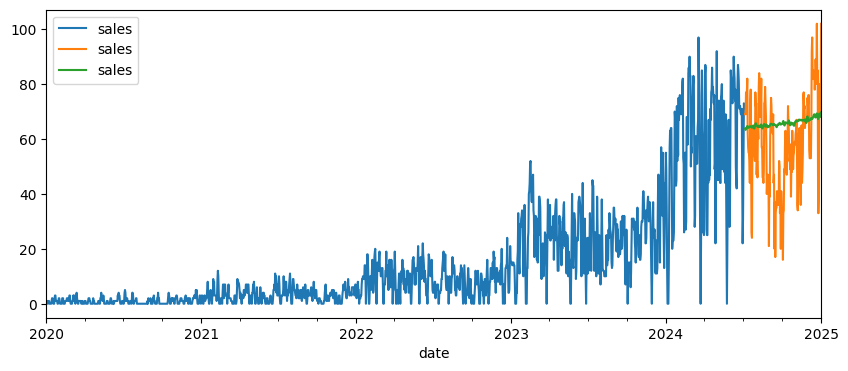

In [44]:
fig, ax = plt.subplots(figsize=(10, 4))
y_train.loc[0].plot(ax=ax, label="Train")
y_test.loc[0].plot(ax=ax, label="Test")
y_pred_nbeats.loc[0].plot(ax=ax, label="N-BEATS")
fig.show()

In [59]:
from pytorch_forecasting.metrics.distributions import NegativeBinomialDistributionLoss
from sktime.forecasting.pytorchforecasting import PytorchForecastingDeepAR
from pytorch_forecasting.data.encoders import TorchNormalizer

CONTEXT_LENGTH = 30
deepar = PytorchForecastingDeepAR(
    train_to_dataloader_params={"batch_size": 512},
    trainer_params={"max_epochs": 1},
    model_params={
        "cell_type" : "LSTM",
        "rnn_layers" : 1,
        "hidden_size": 32,
        "learning_rate": 1e-3,
        "loss": NegativeBinomialDistributionLoss(),
    },
    dataset_params={

        "max_encoder_length": CONTEXT_LENGTH,
        "target_normalizer": EncoderNormalizer(center=False,method="identity")
    },
)

deepar.fit(y_train.astype("float32"), fh=fh)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                   | Type                             | Params | Mode 
------------------------------------------------------------------------------------
0 | loss                   | NegativeBinomialDistributionLoss | 0      | train
1 | logging_metrics        | ModuleList                       | 0      | train
2 | embeddings             | MultiEmbedding                   | 0      | train
3 | rnn                    | LSTM                             | 4.5 K  | train
4 | distribution_projector | Linear                           | 66     | train
------------------------------------------------------------------------------------
4.5 K     Trainable params
0       

Epoch 0: 100%|██████████| 122/122 [00:51<00:00,  2.36it/s, v_num=29, train_loss_step=2.970, val_loss=8.550, train_loss_epoch=3.860]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 122/122 [00:51<00:00,  2.35it/s, v_num=29, train_loss_step=2.970, val_loss=8.550, train_loss_epoch=3.860]


PytorchForecastingDeepAR(dataset_params={'max_encoder_length': 30,
                                         'target_normalizer': EncoderNormalizer(
	method='identity',
	center=False,
	max_length=None,
	transformation=None,
	method_kwargs={}
)},
                         model_params={'cell_type': 'LSTM', 'hidden_size': 32,
                                       'learning_rate': 0.001,
                                       'loss': NegativeBinomialDistributionLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]),
                                       'rnn_layers': 1},
                         train_to_dataloader_params={'batch_size': 512},
                         trainer_params={'max_epochs': 1})